In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

In [2]:
#load file
study=pd.read_excel("BCI studies_data.xlsx")
study=study.drop(labels=["female","male", "percentage male", "Ischemic", "Hemorrhagic", "percentage Hemorrhagic" , "Impaired right", "impaired left", "percentage impaired left", "Cortical", "Subcortical", "Cortico-subcortical"], axis=1)

study.head()

,"Author, year",EG/CG/E/CS,N,mean age,percentage female,percentage Ischemic,percentage impaired right,Percentage Cortical,Percentage Subcortical,Percentage Cortico-subcortical,mean time in months,sessions,BCI+actuated movement,BCI+FES,BCI+Visual,BCI+VR,BCI+Audio,BCI+Vibrotactile,tDCs,Sham-TDCS,Actuated movement,BCI+Sham-actuated movement,FES,BCI+Sham-FES,Visual movement feedback,"MI training, no BCI",Addition of any form of physical practice,Occupational therapy,Behavioural (goal-oriented),Physical therapy,AOT,massage,label
0,Buch et al. (2008),E,8,52.00,0.250000,NaN,0.125000,0.0,0.625,0.375,23.20,17.6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b
1,Prasad et al. (2009),E,5,58.60,0.200000,NaN,0.400000,NaN,NaN,NaN,28.00,12.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,b
2,Shindo et al. (2010),E,8,59.00,0.000000,0.25,0.250000,NaN,NaN,NaN,42.30,14.8,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b
3,Varkuti et al. (2012),EG,6,40.94,0.166667,NaN,0.333333,NaN,NaN,NaN,11.67,12.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a
4,Varkuti et al. (2012),CG,3,50.67,0.333333,NaN,0.333333,NaN,NaN,NaN,6.80,12.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,a


In [3]:
study.shape

(84, 33)

In [4]:
#ratio of "significant" to "no significant improvement" 
acount=0
bcount=0
 
for value in study["label"]:
  if value=="a":acount+=1
  if value=="b":bcount+=1 
 
print(acount, bcount)
print(acount/(acount+bcount))

58 26
0.6904761904761905


In [5]:
#impute missing data
df=study.copy()
df[[ "percentage female", "mean age", "mean time in months", "percentage Ischemic", "percentage impaired right", "sessions", "Percentage Cortical", "Percentage Subcortical", "Percentage Cortico-subcortical" ]]=df[[  "percentage female", "mean age", "mean time in months", "percentage Ischemic",  "percentage impaired right", "sessions", "Percentage Cortical", "Percentage Subcortical", "Percentage Cortico-subcortical"]].fillna(study.mean())

In [6]:
df_imputed=df
df.head()

,"Author, year",EG/CG/E/CS,N,mean age,percentage female,percentage Ischemic,percentage impaired right,Percentage Cortical,Percentage Subcortical,Percentage Cortico-subcortical,mean time in months,sessions,BCI+actuated movement,BCI+FES,BCI+Visual,BCI+VR,BCI+Audio,BCI+Vibrotactile,tDCs,Sham-TDCS,Actuated movement,BCI+Sham-actuated movement,FES,BCI+Sham-FES,Visual movement feedback,"MI training, no BCI",Addition of any form of physical practice,Occupational therapy,Behavioural (goal-oriented),Physical therapy,AOT,massage,label
0,Buch et al. (2008),E,8,52.00,0.250000,0.595277,0.125000,0.000000,0.625000,0.3750,23.20,17.6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b
1,Prasad et al. (2009),E,5,58.60,0.200000,0.595277,0.400000,0.122859,0.632541,0.2446,28.00,12.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,b
2,Shindo et al. (2010),E,8,59.00,0.000000,0.250000,0.250000,0.122859,0.632541,0.2446,42.30,14.8,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b
3,Varkuti et al. (2012),EG,6,40.94,0.166667,0.595277,0.333333,0.122859,0.632541,0.2446,11.67,12.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a
4,Varkuti et al. (2012),CG,3,50.67,0.333333,0.595277,0.333333,0.122859,0.632541,0.2446,6.80,12.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,a


In [7]:
feature_names = [ "percentage female", "mean age", "mean time in months", "percentage Ischemic", "percentage impaired right", "sessions", "Percentage Cortical", "Percentage Subcortical", "Percentage Cortico-subcortical","BCI+actuated movement", "BCI+FES", "BCI+Visual", "BCI+VR", "BCI+Audio", "BCI+Vibrotactile", "tDCs", "Sham-TDCS", "Actuated movement", "BCI+Sham-actuated movement", "FES", "BCI+Sham-FES", "Visual movement feedback", "MI training, no BCI", "Addition of any form of physical practice ", "Occupational therapy", "Behavioural (goal-oriented)", "Physical therapy", "AOT", "massage" ]
X=df[feature_names]
y = df["label"]
print(X.shape, y.shape)

(84, 29) (84,)


#Correlations, permutations (imputed data)

---




In [8]:
df_for_pearson=df.copy()
df_for_pearson.head()

,"Author, year",EG/CG/E/CS,N,mean age,percentage female,percentage Ischemic,percentage impaired right,Percentage Cortical,Percentage Subcortical,Percentage Cortico-subcortical,mean time in months,sessions,BCI+actuated movement,BCI+FES,BCI+Visual,BCI+VR,BCI+Audio,BCI+Vibrotactile,tDCs,Sham-TDCS,Actuated movement,BCI+Sham-actuated movement,FES,BCI+Sham-FES,Visual movement feedback,"MI training, no BCI",Addition of any form of physical practice,Occupational therapy,Behavioural (goal-oriented),Physical therapy,AOT,massage,label
0,Buch et al. (2008),E,8,52.00,0.250000,0.595277,0.125000,0.000000,0.625000,0.3750,23.20,17.6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b
1,Prasad et al. (2009),E,5,58.60,0.200000,0.595277,0.400000,0.122859,0.632541,0.2446,28.00,12.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,b
2,Shindo et al. (2010),E,8,59.00,0.000000,0.250000,0.250000,0.122859,0.632541,0.2446,42.30,14.8,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b
3,Varkuti et al. (2012),EG,6,40.94,0.166667,0.595277,0.333333,0.122859,0.632541,0.2446,11.67,12.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a
4,Varkuti et al. (2012),CG,3,50.67,0.333333,0.595277,0.333333,0.122859,0.632541,0.2446,6.80,12.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,a


In [9]:
df_for_pearson=df_for_pearson.drop(labels=["N"], axis=1)

In [10]:
#transform labels into numeric values 
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(df_for_pearson[["label"]])
enc.categories_

[array(['a', 'b'], dtype=object)]

In [11]:
df_for_pearson["label"]=enc.transform(df_for_pearson[["label"]])
df_for_pearson.head()

,"Author, year",EG/CG/E/CS,mean age,percentage female,percentage Ischemic,percentage impaired right,Percentage Cortical,Percentage Subcortical,Percentage Cortico-subcortical,mean time in months,sessions,BCI+actuated movement,BCI+FES,BCI+Visual,BCI+VR,BCI+Audio,BCI+Vibrotactile,tDCs,Sham-TDCS,Actuated movement,BCI+Sham-actuated movement,FES,BCI+Sham-FES,Visual movement feedback,"MI training, no BCI",Addition of any form of physical practice,Occupational therapy,Behavioural (goal-oriented),Physical therapy,AOT,massage,label
0,Buch et al. (2008),E,52.00,0.250000,0.595277,0.125000,0.000000,0.625000,0.3750,23.20,17.6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,Prasad et al. (2009),E,58.60,0.200000,0.595277,0.400000,0.122859,0.632541,0.2446,28.00,12.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1.0
2,Shindo et al. (2010),E,59.00,0.000000,0.250000,0.250000,0.122859,0.632541,0.2446,42.30,14.8,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,Varkuti et al. (2012),EG,40.94,0.166667,0.595277,0.333333,0.122859,0.632541,0.2446,11.67,12.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,Varkuti et al. (2012),CG,50.67,0.333333,0.595277,0.333333,0.122859,0.632541,0.2446,6.80,12.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0


In [12]:
corr_matrix = df_for_pearson.corr()
corr_matrix["label"].sort_values(ascending=False)

label                                         1.000000
BCI+Sham-FES                                  0.287439
mean time in months                           0.259974
Sham-TDCS                                     0.163941
Percentage Cortico-subcortical                0.094525
BCI+VR                                        0.064347
BCI+Vibrotactile                              0.064347
tDCs                                          0.064347
BCI+Sham-actuated movement                    0.064347
BCI+actuated movement                         0.058078
BCI+Visual                                    0.047977
Behavioural (goal-oriented)                   0.009912
Percentage Subcortical                       -0.005815
percentage female                            -0.027482
percentage Ischemic                          -0.048713
BCI+Audio                                    -0.059602
MI training, no BCI                          -0.073491
AOT                                          -0.073491
percentage

In [13]:
#permutation test
def permutation_test(column1, column2, permutations):
 
  cor=column1.corr(column2)
  was_higher=0 

  for i in range (permutations):
    #create permutation
    column1 = pd.DataFrame(np.random.permutation(column1))  
    permcor=column1[0].corr(column2)
    if(abs(permcor)>=abs(cor)):
        was_higher+=1
  return was_higher/permutations

In [14]:
#10000permutations
for column in corr_matrix:
  print("with "+column+": "+"\t"+str(permutation_test(df_for_pearson["label"],df_for_pearson[column], 10000))+"(p-value)"+"\t"+str(corr_matrix["label"][column])+"(cor)")

with mean age: 	0.377(p-value)	-0.09804212122792319(cor)
with percentage female: 	0.8103(p-value)	-0.027481530802598006(cor)
with percentage Ischemic: 	0.661(p-value)	-0.04871317436054664(cor)
with percentage impaired right: 	0.4774(p-value)	-0.07831010915392099(cor)
with Percentage Cortical: 	0.0699(p-value)	-0.19905767004191469(cor)
with Percentage Subcortical: 	0.9599(p-value)	-0.00581540413332933(cor)
with Percentage Cortico-subcortical: 	0.3957(p-value)	0.09452546871617849(cor)
with mean time in months: 	0.0082(p-value)	0.25997436396107415(cor)
with sessions: 	0.0541(p-value)	-0.208349670517046(cor)
with BCI+actuated movement: 	0.4944(p-value)	0.05807784530333903(cor)
with BCI+FES: 	0.5815(p-value)	-0.08143279274805701(cor)
with BCI+Visual: 	0.6343(p-value)	0.04797735046797545(cor)
with BCI+VR: 	0.9074(p-value)	0.06434686362807035(cor)
with BCI+Audio: 	0.5909(p-value)	-0.05960169532617005(cor)
with BCI+Vibrotactile: 	0.8961(p-value)	0.06434686362807035(cor)
with tDCs: 	0.9574(p-va

#Logistic regression model (train-test split)


In [15]:
#X after normalization

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.250000,0.561404,0.063664,0.595277,0.125000,0.296429,0.000000,0.625000,0.3750,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.200000,0.677193,0.077009,0.595277,0.400000,0.196429,0.286672,0.632541,0.2446,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,0.684211,0.116764,0.250000,0.250000,0.246429,0.286672,0.632541,0.2446,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166667,0.367368,0.031610,0.595277,0.333333,0.196429,0.286672,0.632541,0.2446,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.538070,0.018071,0.595277,0.333333,0.196429,0.286672,0.632541,0.2446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.250000,0.831579,0.000000,0.595277,0.472410,0.041071,0.286672,0.632541,0.2446,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
80,0.500000,0.775439,0.082569,0.500000,0.000000,0.071429,0.583333,0.750000,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.400000,0.543860,0.022797,0.595277,1.000000,0.160714,0.286672,0.632541,0.2446,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
82,0.500000,0.578947,0.023353,0.595277,1.000000,0.160714,0.286672,0.632541,0.2446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [17]:

#inspect label distribution
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )


(67, 29) (17, 29) (67,) (17,)


In [18]:
#train model
clf = LogisticRegression(random_state=0, solver="lbfgs", penalty='none', max_iter=10000)
clf = clf.fit(X_train, y_train)

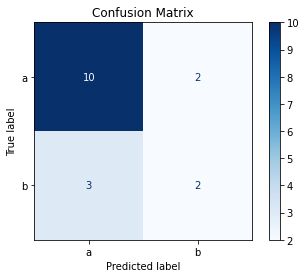

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
class_names=["a","b"]
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [20]:
#cross validation with shuffle split
cv = StratifiedShuffleSplit(n_splits=1000, test_size=0.2, random_state=1)
scores=cross_val_score(clf, X, y, cv=cv)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.58823529 0.35294118 0.70588235 0.76470588 0.70588235 0.47058824
 0.76470588 0.58823529 0.64705882 0.70588235 0.52941176 0.64705882
 0.70588235 0.64705882 0.52941176 0.76470588 0.52941176 0.64705882
 0.76470588 0.58823529 0.82352941 0.52941176 0.64705882 0.58823529
 0.58823529 0.76470588 0.47058824 0.64705882 0.76470588 0.47058824
 0.58823529 0.64705882 0.58823529 0.35294118 0.64705882 0.58823529
 0.82352941 0.76470588 0.64705882 0.47058824 0.58823529 0.82352941
 0.70588235 0.64705882 0.70588235 0.64705882 0.47058824 0.52941176
 0.70588235 0.64705882 0.76470588 0.76470588 0.58823529 0.76470588
 0.52941176 0.82352941 0.58823529 0.52941176 0.70588235 0.70588235
 0.70588235 0.47058824 0.58823529 0.52941176 0.70588235 0.70588235
 0.64705882 0.70588235 0.82352941 0.76470588 0.52941176 0.76470588
 0.58823529 0.58823529 0.58823529 0.64705882 0.41176471 0.70588235
 0.70588235 0.64705882 0.47058824 0.52941176 0.64705882 0.58823529
 0.70588235 0.58823529 0.76470588 0.64705882 0.70588235 0.6470

#Weights (normalized data)




In [21]:
#X after normalization

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.250000,0.561404,0.063664,0.595277,0.125000,0.296429,0.000000,0.625000,0.3750,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.200000,0.677193,0.077009,0.595277,0.400000,0.196429,0.286672,0.632541,0.2446,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,0.684211,0.116764,0.250000,0.250000,0.246429,0.286672,0.632541,0.2446,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166667,0.367368,0.031610,0.595277,0.333333,0.196429,0.286672,0.632541,0.2446,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.538070,0.018071,0.595277,0.333333,0.196429,0.286672,0.632541,0.2446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.250000,0.831579,0.000000,0.595277,0.472410,0.041071,0.286672,0.632541,0.2446,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
80,0.500000,0.775439,0.082569,0.500000,0.000000,0.071429,0.583333,0.750000,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.400000,0.543860,0.022797,0.595277,1.000000,0.160714,0.286672,0.632541,0.2446,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
82,0.500000,0.578947,0.023353,0.595277,1.000000,0.160714,0.286672,0.632541,0.2446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [22]:
X=pd.DataFrame(X)
#train model with all data normalized
clf = LogisticRegression(random_state=4,  solver="lbfgs", penalty='none', max_iter=10000)
clf = clf.fit(X, y)

In [23]:
#weights

for i, feature in enumerate(X.columns):
  print(str(feature)+"\t"+str(-clf.coef_[0][i]))

0	-0.06626793243641066
1	1.5024863437116043
2	-3.581589773269474
3	2.1245146796474623
4	1.0354099671269672
5	5.380957982735154
6	1.501647478289724
7	-1.7519103877259419
8	-2.860479042737499
9	1.7234590073340919
10	2.369857693257293
11	0.05026993685953766
12	0.41796585610255566
13	1.36281889095371
14	0.41796585610255566
15	-0.5757283905577162
16	-61.1614686005311
17	45.68630725565341
18	-93.63150927302739
19	75.08340024152174
20	-42.053584620140526
21	19.295884821482318
22	60.90638400927732
23	3.4057751630685043
24	-1.018656484443619
25	36.87104237629198
26	-0.9773082377342689
27	9.684609541468115
28	55.417651252739944


In [24]:
#weights averaged over 100
coef_list=[0]*len(X.columns)

#compute weights 100 times
for i in range(0,100):
  clf = LogisticRegression(random_state=i, solver="lbfgs", penalty="none", max_iter=10000)
  clf = clf.fit(X, y)
  for j, feature in enumerate(X.columns):
    coef_list[j]+=-clf.coef_[0][j]

#average weights    
for i in range(len(X.columns)):
  coef_list[i]=coef_list[i]/100

#print weights
for i, feature in enumerate(X.columns):
  print(str(feature)+"\t"+str(coef_list[i]))

0	-0.06626793243641062
1	1.5024863437116067
2	-3.581589773269472
3	2.124514679647462
4	1.0354099671269668
5	5.3809579827351435
6	1.5016474782897256
7	-1.7519103877259385
8	-2.860479042737497
9	1.7234590073340916
10	2.369857693257296
11	0.05026993685953763
12	0.417965856102555
13	1.3628188909537085
14	0.417965856102555
15	-0.5757283905577154
16	-61.16146860053116
17	45.68630725565344
18	-93.63150927302739
19	75.08340024152155
20	-42.05358462014053
21	19.29588482148233
22	60.906384009277396
23	3.405775163068501
24	-1.0186564844436206
25	36.871042376291925
26	-0.9773082377342677
27	9.684609541468125
28	55.41765125274006


In [25]:
#print weights
for i, feature in enumerate(X.columns):
  weights_list= feature_names[i]+"\t"+str(coef_list[i])
  print(weights_list)

percentage female	-0.06626793243641062
mean age	1.5024863437116067
mean time in months	-3.581589773269472
percentage Ischemic	2.124514679647462
percentage impaired right	1.0354099671269668
sessions	5.3809579827351435
Percentage Cortical	1.5016474782897256
Percentage Subcortical	-1.7519103877259385
Percentage Cortico-subcortical	-2.860479042737497
BCI+actuated movement	1.7234590073340916
BCI+FES	2.369857693257296
BCI+Visual	0.05026993685953763
BCI+VR	0.417965856102555
BCI+Audio	1.3628188909537085
BCI+Vibrotactile	0.417965856102555
tDCs	-0.5757283905577154
Sham-TDCS	-61.16146860053116
Actuated movement	45.68630725565344
BCI+Sham-actuated movement	-93.63150927302739
FES	75.08340024152155
BCI+Sham-FES	-42.05358462014053
Visual movement feedback	19.29588482148233
MI training, no BCI	60.906384009277396
Addition of any form of physical practice 	3.405775163068501
Occupational therapy	-1.0186564844436206
Behavioural (goal-oriented)	36.871042376291925
Physical therapy	-0.9773082377342677
AOT	9.

In [26]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.250000,0.561404,0.063664,0.595277,0.125000,0.296429,0.000000,0.625000,0.3750,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.200000,0.677193,0.077009,0.595277,0.400000,0.196429,0.286672,0.632541,0.2446,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,0.684211,0.116764,0.250000,0.250000,0.246429,0.286672,0.632541,0.2446,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166667,0.367368,0.031610,0.595277,0.333333,0.196429,0.286672,0.632541,0.2446,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.538070,0.018071,0.595277,0.333333,0.196429,0.286672,0.632541,0.2446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.250000,0.831579,0.000000,0.595277,0.472410,0.041071,0.286672,0.632541,0.2446,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
80,0.500000,0.775439,0.082569,0.500000,0.000000,0.071429,0.583333,0.750000,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.400000,0.543860,0.022797,0.595277,1.000000,0.160714,0.286672,0.632541,0.2446,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
82,0.500000,0.578947,0.023353,0.595277,1.000000,0.160714,0.286672,0.632541,0.2446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


#Logistic regression - model trained on all data

In [27]:
#train model
clf = LogisticRegression(random_state=0,  solver="lbfgs", penalty='none', max_iter=10000)
clf = clf.fit(X, y)

In [28]:
#cross validation with shuffle split

score_alldata=clf.score(X,y)
print(score_alldata)


0.8214285714285714


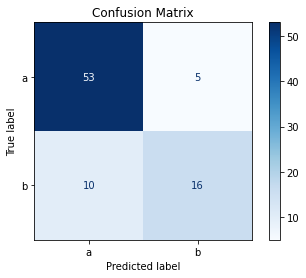

In [29]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
class_names=["a","b"]
disp = plot_confusion_matrix(clf, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

#p-value for model 

In [30]:
from sklearn.model_selection import RepeatedKFold



In [31]:
#generate 6-fold CV over 100 repetitions
cv = RepeatedKFold(n_splits=6, n_repeats=100, random_state=0)

In [32]:

i=0
value_counter=0
mean_shuffled=0
mean_unshuffled=0
scores_shuffled=[]
scores_unshuffled=[]

#iterate over each split 
for train_index, test_index in cv.split(X):
  i+=1

  #split the data
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_train_shuffled = y_train.sample(len(y_train)).reset_index(drop=True)

  #train
  clf_shuffled = LogisticRegression(random_state=0, solver="lbfgs", penalty='none', max_iter=10000)
  clf_unshuffled = LogisticRegression(random_state=0, solver="lbfgs", penalty='none', max_iter=10000)
  clf_shuffled = clf_shuffled.fit(X_train, y_train_shuffled)
  clf_unshuffled = clf_unshuffled.fit(X_train, y_train)

  #score for this specific split
  shuffled_score=clf_shuffled.score(X_test, y_test)
  unshuffled_score=clf_unshuffled.score(X_test, y_test)
  mean_shuffled+=shuffled_score 
  mean_unshuffled+=unshuffled_score

#compute accuracy mean over every 6 iterations
  if i%6==0:
    scores_shuffled.append(mean_shuffled/6)
    scores_unshuffled.append(mean_unshuffled/6)
    mean_shuffled=0
    mean_unshuffled=0
    print(i)





6
12
18
24
30
36
42
48
54
60
66
72
78
84
90
96
102
108
114
120
126
132
138
144
150
156
162
168
174
180
186
192
198
204
210
216
222
228
234
240
246
252
258
264
270
276
282
288
294
300
306
312
318
324
330
336
342
348
354
360
366
372
378
384
390
396
402
408
414
420
426
432
438
444
450
456
462
468
474
480
486
492
498
504
510
516
522
528
534
540
546
552
558
564
570
576
582
588
594
600


In [33]:
#compute difference between scores 
differences=[]
for i in range(len(scores_shuffled)):
  difference=scores_unshuffled[i]-scores_shuffled[i]
  differences.append(difference)
print(sum(differences)/len(differences))  
reference_score=sum(differences)/len(differences)

0.053333333333333316


In [34]:
print(sum(scores_unshuffled)/len(scores_unshuffled))

0.6179761904761905


In [35]:
#compute differences in scores 10000 times, randomly assigning each mean-score to be the shuffled vs the unshuffled one 
import random

p_counter = 0
for i in range(1000):
  differences=[]
  for i in range(len(scores_shuffled)):
    if random.choice([True, False]):
      difference=scores_unshuffled[i]-scores_shuffled[i]
    else:
      difference=scores_shuffled[i]-scores_unshuffled[i]
    differences.append(difference)
  if sum(differences)/len(differences)>=reference_score:p_counter+=1
print(p_counter/1000)

0.0
